In [1]:
import pandas as pd 
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client, SSHCluster, LocalCluster
from dask import delayed
import dask 
import time
from datetime import datetime
import pandas as pd
import logging 
import pytz
import matplotlib.pyplot as plt
import os
import psutil
import signal
import math
import csv

pd.options.display.max_rows = 100

# Data Preprocessing and Filtering 

Our aim is to clean the datasets by removing all the informations that will be unnecessary for further analysis. To achieve this, the main steps we will undertake are:

- Load the dataset containing the evolutionary and initial conditions of the systems.
- Remove all the labels that are irrelevant for our analysis.
- Select the systems that, at a certain point in their evolution, become Wolf-Rayet - black hole binaries.
- Identify which of these systems undergo mass transfer proccesses.
- Determine which of these systems evolve into BBHs.
- Assess which of these BBHs systems end up merging via gravitational waves emission.


We choose to employ the Python open-source library Dask for this task. Given that the dataset we are working with is too large to fit in memory, Dask is an optimal solution as it is designed for parallel computing, enabling Python code to scale across multiple multi-core machines.\
The parallelization of the computing process is performed on a cluster of virtual machines provided by the cloud service CloudVeneto.

## 1. The cluster

The cluster consists of three CloudVeneto virtual machines. Each machine has 8GB RAM and 4 CPU logical cores. The cluster is able to operate through ssh connections, where each individual client communicates via RSA allowing for passwordless communication. The three VMs are aliased in /etc/hosts as `binary01` (IP 10.67.22.174), `binary02` (IP 10.67.22.251) and `binary03` (IP 10.67.22.93).

Each machine in the Dask cluster is part of an NFS cluster, along with another machine (IP 10.67.22.36), which serves as the NFS server. The server hosts a mounted volume that contains all our data. The other three machines in the cluster function as clients, allowing them to access the data on the NFS server simultaneously.

Dask instantiates Client objects as ssh-clusters through the method `SSHCluster` of `dask.distributed`, which in turn is built upon the paramiko package for ssh communication with Python. We instanciate it by:

- Specifing a list with the aliases related to the IPs of the machines that compose the SSH cluster
- Setting `known_hosts` to None for the connection options: this tells the SSH client to not check the `known_hosts` file for host key verification. By that that the SSH client will not validate the server's host key against known hosts. This allow us to avoid manual host key verification prompts.\
  In addition to that, we pass the password we use as user to access the VMs.
- Setting the port that the Dask scheduler will use for communication with the dashboard. By default we use the 8788.
- Setting the number of worker for each host (i.e. machine), and the number of threads for each worker.


<div style="text-align: center;">
    <img src="immagini/cluster.png" alt="Image", width="400">
    <figcaption>Fig.1 - Diagram of the cluster  </figcaption>
</div>

In [3]:
def kill_dask_processes(user):
    """
    This function is able to kill every active dask process opened by a specific user. It does so by using bash commands. 
    
    Args:
        user (str): the username of the user who started the dask processes this function will kill
        Attention! This username must be your username: you can not close active dask processes opened by other users 
        (even if the function will say it killed it)
    
    Returns:
        void
    
    """
    #iterating over all active processes
    for proc in psutil.process_iter(['username','pid', 'name', 'cmdline']):
        try:       
            # Check if the process command line contains 'distributed.cli.dask_spec' and username passed as argument
            if 'python' in proc.info['name'] and 'distributed.cli.dask_spec' in proc.info['cmdline'] and user in proc.info['username']:     
                pid = proc.info['pid']  #storing the identifier to the process
                
                proc.send_signal(signal.SIGTERM) #terminating the process
                print(f"Terminating process {pid} - {' '.join(proc.info['cmdline'])}")

        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            continue


#Example of usage:
kill_dask_processes(user)

In [4]:
def init_client(password=None, nworkers=1, nthreads=4):
    """
    This function initializes the dask cluster and client.

    Args:
        nworkers (int): Number of dask workers per host (each VM composing the cluster is a host), default is 1
        nthreads (int): Number of utilized threads per worker, default 4

    Returns:
        dask cluster object
        dask client object
    
    """ 
    
    cluster = SSHCluster(
        ["binary01", "binary01", "binary02", "binary03"], #the first one in the list is the scheduler alias, the other three are workers (the scheduler can act also as worker)
        connect_options={"known_hosts":None, "password":password},
        worker_options={"nthreads": nthreads, "n_workers": nworkers},
        scheduler_options = {"dashboard_address": ":8787"}
    )
        
    client=Client(cluster)

    return cluster, client

def close_cluster(cluster, client, user):
    """
    This function closes the cluster and the client, ensuring that every dask process started from the user is terminated.
    
    Parameters:
    - cluster (dask object): the dask cluster to be closed
    - client (dask object): the dask client to be closed  
    - user (str): the username of the user whose dask processes are to be killed via bash commands
    
    Returns:
    - void
    """
    
    cluster.close()
    client.close()
    kill_dask_processes(user)

In [11]:
cluster, client = init_client(password=password)
#close_cluster(cluster, client, user)

2024-09-02 15:53:13,981 - distributed.deploy.ssh - INFO - 2024-09-02 15:53:13,980 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-02 15:53:14,008 - distributed.deploy.ssh - INFO - 2024-09-02 15:53:14,008 - distributed.scheduler - INFO - State start
2024-09-02 15:53:14,010 - distributed.deploy.ssh - INFO - 2024-09-02 15:53:14,009 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space-1000/worker-apz31bon', purging
2024-09-02 15:53:14,012 - distributed.deploy.ssh - INFO - 2024-09-02 15:53:14,012 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.174:46157
2024-09-02 15:53:14,449 - distributed.deploy.ssh - INFO - 2024-09-02 15:53:14,449 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.174:35119'
2024-09-02 15:53:14,782 - distributed.deploy.ssh - INFO - 2024-09-02 15:53:14,781 - distributed.worker - INF

## 2. The dataset

The dataset consists of two outputs computed at different metallicities (Z=0.00014 and Z=0.02) by the population synthesis code SEVN. We work with binary systems whose evolution is described by SEVN including the following processes: wind mass transfer, Roche-lobe overflow (RLO), common envelope (CE), stellar tides, circularization at the RLO onset, collision at periastron, orbit decay by GW emission, and stellar mergers.

SEVN uses a prediction-correction method to adapt the time-step accounting for the large physical range of timescales typical of stellar and binary evolution. To decide the time-step, it looks at a sub-set of stellar and binary properties: if any of them changes too much during a time-step, it reduces the time-step and repeats the calculation. A special treatment is used when a star approaches a change of phase to guarantee that the stellar properties are evaluated just after and before the change of phase. 

#### 2.1 Dataset Structure

Each dataset, corresponding to a specific metallicity, includes two types of files:

- Evolved Files (`evolved_n.dat`): Contain initial conditions of the simulations.
- Output Files (`output_n.csv`): Document the evolution of the systems over time.

The files are paired by an integer 'n' (e.g., evolved_0.dat and output_0.csv), with each system identified by a unique 'ID' label. 

#### 2.2 Folder Organization

The datasets are stored in the `/mnt/data` directory, organized into subdirectories based on metallicity. These subdirectories contain the output_*.csv files:

    Z0.02_a3_cM70: Contains a single file, output_0.csv.
    Z0.00014_a3_cM70: Contains 40 files named output_*.csv (e.g., output_0.csv to output_39.csv).

The corresponding evolved files are located in the `/mnt/data/initial` folder, which is similarly organized by metallicity.

<div style="text-align: center;">
    <img src="immagini/tree.png" alt="Image" width="300"/>
    <figcaption>Fig.2 - Tree structure of the dataset</figcaption>
</div>

## 3. First parallelization technique: Unified Analysis

The primary scientific goal is to identify the key parameters that determine whether a black hole – Wolf-Rayet star system will evolve into a binary black hole (BBH) system that eventually merges through the emission of gravitational waves within a Hubble time.

Our initial approach involves loading the entire dataset at once using the **Dask-DataFrame** API. Dask manages dataset partitioning and, by utilizing delayed functions, also handles parallelization of the workload. 

We first define a function to return the path of the files to be read by the *read_csv* method.

In [5]:
def grab_paths(metallicity, n=None, main_path='/mnt/data/'):
    """
    This function returns the paths of the 'output' type files and 'evolved' type files, associated with a given metallicity.
    
    Args:
        metallicity (str): The metallicity of the systems whose evolution is described inside the dataset.   
        n (int, optional): The number of file paths to return from each directory. If None, returns all files. Defaults to None.
        main_path (str): The path of the folder containing all the datasets.
    
    Returns:
        list: A list of strings with the paths to the 'output' type files (output_*.csv).
        list: A list of strings with the paths to the 'evolved' type files (evolved_*).
    """
    
    subfolders = os.listdir(main_path)  # List with the names of the subfolders contained in main_path

    # Retrieving the path of the directory containing 'output' files
    out_dir = None
    for subfolder in subfolders:
        if subfolder == metallicity:
            out_dir = os.path.join(main_path, subfolder)
            break

    if not out_dir:
        print("Error: No directory found for the specified metallicity")
        return None, None

    # Retrieving the path of the 'initial' directory, containing initial conditions for every system in our dataset
    initial_dir = os.path.join(main_path, 'initial')
    if not os.path.exists(initial_dir):
        print("Error: Initial directory not found")
        return None, None

    # Retrieving the path of the directory containing 'evolved' files
    ev_dir = None
    subfolders_initial = os.listdir(initial_dir)  # List with the names of the subfolders contained inside the 'initial' folder
    for subfolder in subfolders_initial:
        if subfolder == metallicity:
            ev_dir = os.path.join(initial_dir, subfolder)
            break

    if not ev_dir:
        print("Error: No directory found for the specified metallicity in initial")
        return None, None

    # Get the list of files in each directory
    output_files = sorted(f for f in os.listdir(out_dir) if f.startswith('output_') and f.endswith('.csv'))
    evolved_files = sorted(os.listdir(ev_dir))
    
    # If n is specified, limit the number of files returned
    if n is not None:
        output_files = output_files[:n]
        evolved_files = evolved_files[:n]
    
    out_paths = [os.path.join(out_dir, f) for f in output_files]
    ev_paths = [os.path.join(ev_dir, f) for f in evolved_files]

    return out_paths, ev_paths

# Example of usage
metallicity = 'Z0.00014_a3_cM70'   
paths = grab_paths(metallicity, n=3)
print(paths)

(['/mnt/data/Z0.00014_a3_cM70/output_0.csv', '/mnt/data/Z0.00014_a3_cM70/output_1.csv', '/mnt/data/Z0.00014_a3_cM70/output_10.csv'], ['/mnt/data/initial/Z0.00014_a3_cM70/evolved_0.dat', '/mnt/data/initial/Z0.00014_a3_cM70/evolved_1.dat', '/mnt/data/initial/Z0.00014_a3_cM70/evolved_10.dat'])


Our analysis consists of the following steps:

1. Selecting systems that at a certain timestep of their evolution become Wolf-Rayet (PhaseBSE={7, 8}) - Black hole (PhaseBSE=14) systems;
2. Counting the number of stable (BEvent=5) / unstable (BEvent={7,11}) mass transfer events for such systems throughout their evolution;
3. Selecting binary black holes (PhaseBSE=14) that eventually merge via emission of gravitational waves. To do so we require that the sum of _GWtime_ (GW orbital decay time in Myr) and _BWorldtime_ (time elapsed in the simulations) is smaller than 14 billions years, the Hubble time;
4. Checking whether WR-BH systems become merging BBHs.

In [6]:
def process_stability(df_WRBH, fold_by):
    """
    This function processes the provided DataFrame to count the number of stable and unstable mass transfer events for each WR-BH system.

    Args:
        df_WRBH: A DataFrame containing data about the evolution of systems that are WR-BH binaries at any timestep.
        fold_by (bool): A boolean indicating whether to use the 'foldby' method for processing. If True, the function will use Dask's foldby method; 
                        if False, it will use the groupby method.

    Returns:
        DataFrame: A DataFrame with two columns for each unique system 'ID':
            - 'MTEvents_stable': The count of stable mass transfer events.
            - 'MTEvents_unstable': The count of unstable mass transfer events.
    """
    
    df_WRBH_stability =  df_WRBH[ ['ID', 'BEvent'] ]

    if fold_by == False:
        
        #counting the numbers of stable ('BEvent'=5) events for each ID 
        n_stable = df_WRBH_stability[df_WRBH_stability['BEvent'] == 5].groupby('ID').size().reset_index().rename(columns={0: 'MTEvents_stable'})
        
        #counting the numbers of unstable ('BEvent'=7,11) events for each ID 
        n_unstable = df_WRBH_stability[ df_WRBH_stability['BEvent'].isin([7, 11]) ].groupby('ID').size().reset_index().rename(columns={0: 'MTEvents_unstable'})

    else: 

        add = lambda x, y: x + y
        
        #counting the numbers of stable ('BEvent'=5) events for each ID 
        n_stable = df_WRBH_stability[df_WRBH_stability['BEvent']==5]\
                    .to_bag()\
                    .foldby(lambda x: x[0], binop=lambda x, _: x + 1, initial=0, combine=add, combine_initial=0)\
                    .to_dataframe(columns=['ID', 'MTEvents_stable'])
        
        #counting the numbers of unstable ('BEvent'=7,11) events for each ID
        n_unstable = df_WRBH_stability[df_WRBH_stability['BEvent'].isin([7, 11])]\
                    .to_bag()\
                    .foldby(lambda x: x[0], binop=lambda x, _: x + 1, initial=0, combine=add, combine_initial=0)\
                    .to_dataframe(columns=['ID', 'MTEvents_unstable'])
        
    #combining the two dataframes 
    mass_transfer = n_stable.merge(n_unstable, how='outer', on='ID')
        
    #substituting the NA entries with 0s and converting the data to ints
    mass_transfer['MTEvents_unstable'] = mass_transfer['MTEvents_unstable'].fillna(0).astype(int) 
    mass_transfer['MTEvents_stable'] = mass_transfer['MTEvents_stable'].fillna(0).astype(int)

    return mass_transfer

def process_binaryBH(df):
    """
    This function analyzes which systems end up forming binary Black-Holes (BBHs) that merge via gravitational waves emission.
        Attention: All types of systems are to be considered, not only WR-BH binaries.
        
    Args:
        df (dataframe): the complete dataset.
 
    Returns:
        dataframe: single-column dataframe with the 'ID's of systems that end up in merging BBHs.
    """
    
    #filtering the merging BH-BH systems from the full dataset 
    cond_GW = (df['PhaseBSE_0'] == 14.0) & (df['PhaseBSE_1'] == 14.0) & \
              ((df['GWtime'] + df['BWorldtime']) < int(14e+03))
    
    #retreiving only the ids, converting to a dataframe 
    id_GW = df[cond_GW]['ID'].drop_duplicates()

    return id_GW
    

def output_analysis(df, fold_by):
    """
    This function provides the complete analysis of an 'output' type file.
    
    Args:
        df (dataframe): the complete dataset. 
    
    Returns:
        dataframe: data regarding the evolutions of WR-BH systems.
    """
    
    ### SELECTING SYSTEMS THAT AT A CERTAIN POINT IN THEIR EVOLUTION BECOME A WR-BH BINARY
    cond_WRBH = (((df['PhaseBSE_0'] == 8) | (df['PhaseBSE_0'] == 7)) & (df['PhaseBSE_1'] == 14.0)) | \
                (((df['PhaseBSE_1'] == 8) | (df['PhaseBSE_1'] == 7)) & (df['PhaseBSE_0'] == 14.0))
    
    # filtering and removing furtherly useless labels
    df_WRBH = df[cond_WRBH].drop(['PhaseBSE_0', 'PhaseBSE_1'], axis=1)
    
    ### DETERMINING NUMBER OF STABLE/UNSTABLE MASS TRANSFER EVENTS 
    mass_transfer = process_stability(df_WRBH, fold_by)
    
    
    ### SELECTING ONLY WR-BH THAT UNDERGO MASS TRANSFER EVENTS
    # discarding all duplicate on ID from the main dataframe
    df_WRBH = df_WRBH.drop_duplicates(subset='ID')
    #merging the main dataframe with the one containing info about stability of the mass transfere events
    data = mass_transfer.merge(df_WRBH, how='inner', on='ID')

    
    ### DETERMINING IDs OF MERGING BBHs
    id_GW = process_binaryBH(df)

    ### ADDING LABEL 'MERGE' IN THE MAIN DATAFRAME: 1 IF THE WR-BH SYSTEM EVOLVEs INTO a MERGING BBH
    id_GW = id_GW.to_frame(name='ID').assign(Merge=1)
    data = data.merge(id_GW, how='left', on='ID').fillna({'Merge': 0})   
    
    return data


def final_analysis(paths, fold_by=False, npartitions=None):
    """
    This function provides the complete analysis
    
    Args:
        paths (tuple): lists of strings with the paths to the 'output' and 'evolved' type files.
 
    Returns:
        dataframe: data regarding the evolution and the initial condition of WR-BH systems.
    """
     
    path_out, path_ev = paths
    
    #processing output file
    columns_to_keep = ['ID', 'Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'BEvent', 'PhaseBSE_0', 'PhaseBSE_1', 'GWtime', 'BWorldtime']
    
    df_out = dd.read_csv(path_out, usecols=columns_to_keep)
    if npartitions is not None:
        df_out.repartition(npartitions=npartitions)
    
    data_out = output_analysis(df_out, fold_by)

    #processing evolved file
    columns_to_keep_ev = ["#ID", "Mass_0", "Mass_1", "a", "e"]
    df_ev =  dd.read_csv(path_ev, usecols=columns_to_keep_ev,  sep='\s+').rename(columns={"#ID": "ID"}).rename(columns={"Mass_0": "Mass_0_initial"}).rename(columns={"Mass_1": "Mass_1_initial"})      #renaming
    if npartitions is not None:
        df_ev = df_ev.repartition(npartitions=int(npartitions/30))
    
    #merging evolved-output 
    data = data_out.merge(df_ev, how='inner', on='ID') 
    
    return data

In [11]:
metallicity =  'Z0.00014_a3_cM70'   
paths = grab_paths(metallicity, n=5)

start_time = time.time()
final_data = final_analysis(paths).compute()
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")

final_data.head(10)

Execution Time: 38.02018594741821 seconds


,ID,MTEvents_stable,MTEvents_unstable,Mass_0,Mass_1,Semimajor,Eccentricity,BWorldtime,GWtime,BEvent,Merge,Mass_0_initial,Mass_1_initial,a,e
0,73000,0,1,9.595676,32.030470,12.62487,0.0,3.674390,2.982537e+02,11,1.0,146.187,62.227,4030.0,0.181000
1,380010,1,0,21.604920,3.524800,464.27620,0.0,21.192870,3.646816e+09,-1,0.0,24.257,10.297,139.0,0.017100
2,532727,1,0,8.021733,1.423993,106.31920,0.0,39.411340,1.778760e+08,-1,0.0,22.051,7.008,449.0,0.298000
3,690102,1,0,11.790760,2.070240,96.22492,0.0,9.983089,3.806061e+07,-1,0.0,30.358,14.973,40.1,0.028500
4,1610064,1,0,30.234210,7.661455,134.66910,0.0,10.175470,5.628009e+06,-1,0.0,40.490,15.998,138.0,0.638000
5,1700033,1,0,12.580780,9.535622,14.86864,0.0,9.103206,2.766918e+03,-1,1.0,31.282,16.214,74.8,0.563000
6,1993003,0,1,30.277070,47.983060,101.68420,0.0,3.278541,1.412390e+05,11,0.0,96.925,68.637,3840.0,0.775000
7,2052660,2,0,18.722820,0.887042,245.03230,0.0,74.654230,1.662592e+09,-1,0.0,41.029,5.036,326.0,0.029800
8,2092607,1,0,36.137280,29.261360,74.31599,0.0,4.528041,6.625111e+04,-1,0.0,72.596,41.167,167.0,0.055800
9,2182662,1,0,23.488060,7.065115,20.75939,0.0,6.638623,5.501977e+03,-1,0.0,28.025,25.543,102.0,0.000257


### 3.1 Exploration of the group-by and fold-by operations for data aggregation

The *groupby* method shuffles the data so that all items with the same key are grouped together in the same key-value pair. This operation is useful for tasks that involve grouping data by a specific key.

The *foldby* method walks through the data and accumulates a result per key. It combines the functionality of groupby and a reduction operation, making it suitable for efficient parallel split-apply-combine tasks.

We apply both methods to a smaller subset of the actual dataset to evaluate their performance.

In [13]:
metallicity =  'Z0.00014_a3_cM70'   
paths = grab_paths(metallicity, n=10)

In [37]:
start_time = time.time()
final_data = final_analysis(paths).compute()
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")

Execution Time: 82.46201181411743 seconds


In [14]:
start_time = time.time()
final_data = final_analysis(paths, fold_by=True).compute()
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")

Task exception was never retrieved
future: <Task finished name='Task-94' coro=<Client._gather.<locals>.wait() done, defined at /home/volpi/.local/lib/python3.10/site-packages/distributed/client.py:2382> exception=AllExit()>
Traceback (most recent call last):
  File "/home/volpi/.local/lib/python3.10/site-packages/distributed/client.py", line 2391, in wait
    raise AllExit()
distributed.client.AllExit


Execution Time: 369.484427690506 seconds


We clearly see how the *groupby* method works better for our computation. This could be explained by the fact that Dask DataFrames provide efficient implementations of operations that involve minimal shuffling, such as group-based aggregations and merge operations. This means that operations like groupby are still reasonably fast, thanks to extensive under-the-hood optimizations.

## 4. Second parallelization technique: Pairwise Analysis

Another possible approach to the analysis task involves reading and processing files in pairs, with each pair consisting of an 'evolved' file and its corresponding 'output' file. As mentioned earlier, each 'output' file uniquely corresponds to an 'evolved' file. For instance, for a given integer *n*, the file output_n.csv contains data related to the evolution of systems whose initial conditions are stored in evolved_n.dat. Below, we present the implementation of this pairwise analysis technique.

We start by defining a function to retrieve the paths of the files to be analyzed. Unlike the previous approach, this method returns a pair of file paths, one for each corresponding 'evolved' and 'output' file.

In [8]:
def grab_dir_paths(metallicity, main_path='/mnt/data/'):
    """
    This function return the paths to the folders containing 'output' type files and 'evolved' type files, associated to a given metallicity.
    
    Args:
        metallicity (str): The metallicity of the systems whose evolution is described inside the dataset. 
        main_path (str): The path of the folder contaning all the datasets.  
    
    Returns:
        str: A string with the path to the folder contianing 'output' type files, i.e. the files regarding the evolution of the systems.
        str: A string with the path to the folder contianing 'evolved' type files, i.e. the files regarding the initial conditions of the systems.
    """
    
    subfolders = os.listdir(main_path) # list with the names of the subfolders contained in main_path

    # Retrieving the path of the directory containing 'ouput' files
    i = 0
    for subfolder in subfolders:
        if subfolder == metallicity:
            out_dir = os.path.join(main_path, subfolder)
            i+=1
    if i!=1: 
        print("Error: Multiple or no directories found for the specified metallicity")
        return 0

    
    # Retrieving the path of the 'initial' directory, containing initial conditions for every systems of our dataset
    try:
        initial_dir = os.path.join(main_path, 'initial')

    except: 
        print("Error: Initial directory not found")
        return 0


    # Retrieving the path of the directory containing 'evolved' files
    subfolders_initial = os.listdir(initial_dir) # list with the names of the subfolders contained inside the 'initial' folder
    
    i = 0
    for subfolder in subfolders_initial:
        if subfolder == metallicity:
            ev_dir = os.path.join(initial_dir, subfolder)
            i+=1

    if i!=1: 
        print("Error: Multiple or no directories found for the specified metallicity in initial")
        return 0    

    return out_dir, ev_dir



def grab_pair_paths(metallicity, n=None):
    """
    This function pairs the paths to an evolved file with the corresponding output file and return a specific number of these pairs.
    
    Args:
        metallicity (str): The metallicity of the systems whose evolution is described inside the dataset.
        n (int): Number of pairs to be returned.
    
    Returns:
        list: list of tuples. Each tuple contains the filepaths to the pair of files, as strings.
    """

    # if the number of filepath to be read is  not specified, read all 
    if n==None:
        if metallicity=='Z0.02_a3_cM70':
            n=1
        if metallicity=='Z0.00014_a3_cM70':
            n=40       
        print('Reading all the : ', n, 'paths \n')
        
    # if the number of filepaths required is not compatible with the actual filepath stored
    if metallicity=='Z0.02_a3_cM70' and n!=1:
        print('Error: incompatible number of path required')
        return 0
    if metallicity=='Z0.00014_a3_cM70' and n>40 and n<1:
        print('Error: incompatible number of path required')
        return 0    

    #retrieving the folder paths
    out_dir, ev_dir = grab_dir_paths(metallicity)

    # List all 'output' files in the out_dir    
    out_files = [f for f in os.listdir(out_dir) if f.endswith('.csv')] #to filter out the 'logfiles'
    sorted_out_files = sorted(out_files, key=lambda x: int(x.split('_')[1].split('.')[0])) #the lambda function extract the index of the file, which is between the _ and . (es. 'output_0.csv)
    
    # List all 'evolved' files in the ev_dir
    ev_files = os.listdir(ev_dir) #there are no log files in the 'initial' folder type files
    sorted_ev_files = sorted(ev_files, key=lambda x: int(x.split('_')[1].split('.')[0])) #the lambda function extract the index of the file, which is between the _ and . (es. 'evolved_0.dat)

    # pairing filepaths
    pairs = []
    for o,e in zip(sorted_out_files, sorted_ev_files):
        # completing the paths 
        o = os.path.join(out_dir,o) 
        e = os.path.join(ev_dir,e) 
        
        pairs.append((o,e))

    return pairs[:n] # returning the number of filepaths pairs required 
    
# Example of usage
metallicity =  'Z0.00014_a3_cM70'   
pair_paths_list = grab_pair_paths(metallicity, n=3)
print(pair_paths_list)

[('/mnt/data/Z0.00014_a3_cM70/output_0.csv', '/mnt/data/initial/Z0.00014_a3_cM70/evolved_0.dat'), ('/mnt/data/Z0.00014_a3_cM70/output_1.csv', '/mnt/data/initial/Z0.00014_a3_cM70/evolved_1.dat'), ('/mnt/data/Z0.00014_a3_cM70/output_2.csv', '/mnt/data/initial/Z0.00014_a3_cM70/evolved_2.dat')]


In [9]:
def processing_pair(pair, fold_by):
    """
    This function provides the complete analysis of a single pair of 'evolved'-'output' files.
    
    Args:
        pair (tuple): tuple of strings, containing the paths to the two files.
 
    Returns:
        dataframe: data regarding the evolution and the initial condition of systems that turn into a WR-BH, contained inside the file pair.
    """
     
    path_out, path_ev = pair
    
    #processing output file
    columns_to_keep = ['ID', 'Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'BEvent', 'PhaseBSE_0', 'PhaseBSE_1', 'GWtime', 'BWorldtime']

    df_out = dd.read_csv(path_out, usecols=columns_to_keep)
    data_out = output_analysis(df_out, fold_by)

    #processing evolved file
    columns_to_keep_ev = ["#ID", "Mass_0", "Mass_1", "a", "e"]
    df_ev =  dd.read_csv(path_ev, usecols=columns_to_keep_ev,  sep='\s+').rename(columns={"#ID": "ID"}).rename(columns={"Mass_0": "Mass_0_initial"}).rename(columns={"Mass_1": "Mass_1_initial"})      #renaming
    
    #merging evolved-output 
    data_pair = data_out.merge(df_ev, how='inner', on='ID') 
    
    return data_pair


def processing_pairs(pairs, fold_by=False):
    """
    This function provides the complete analysis of multiple pairs of 'evolved'-'output' files.
        
    Args:
        pairs (list): list of tuples. Each tuple is composed of two strings: the paths to the two paired 'output'-'evolved' files.
 
    Returns:
        dataframe: data regarding the evolution and the initial condition of systems that turn into a WR-BH, 
                    contained inside all the file pairs provided.
    """
    
    all_data = []  # List to collect dataframes   
    for pair in pairs:          
        data_pair = processing_pair(pair, fold_by)
        
        all_data.append(data_pair)
    
    final_data = dd.concat(all_data, axis=0)    

    return final_data

In [10]:
pairs = grab_pair_paths(metallicity='Z0.00014_a3_cM70')

start_time = time.time()
final_data = processing_pairs(pairs).compute()
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")

final_data.head(10)

Reading all the :  40 paths 

Execution Time: 599.0074496269226 seconds


,ID,MTEvents_stable,MTEvents_unstable,Mass_0,PhaseBSE_0,Mass_1,PhaseBSE_1,Semimajor,Eccentricity,BWorldtime,GWtime,BEvent,Merge,Mass_0_initial,Mass_1_initial,a,e
0,168,1,0,23.35450,14.0,6.591192,8.0,180.92910,0.0,10.806470,3.491784e+07,-1,0.0,26.503,17.081,211.0,0.25600
1,20035,1,0,30.97693,14.0,3.243112,8.0,175.28590,0.0,23.704370,4.124676e+07,-1,0.0,62.429,9.810,706.0,0.00613
2,130166,1,0,32.60421,14.0,7.353376,8.0,134.84770,0.0,9.446935,5.184389e+06,-1,0.0,65.583,19.358,849.0,0.01440
3,250153,1,0,15.59014,14.0,9.230359,7.0,20.90687,0.0,9.265961,8.034512e+03,-1,0.0,35.583,14.986,71.3,0.22000
4,270064,1,0,34.54233,14.0,28.584460,7.0,61.31476,0.0,4.546294,3.406021e+04,-1,0.0,71.013,40.368,177.0,0.38100
5,320197,1,0,22.31402,14.0,2.603306,8.0,160.33990,0.0,32.115740,6.858740e+07,-1,0.0,47.289,8.193,1000.0,0.77300
6,320209,1,0,45.38478,14.0,43.225270,7.0,82.08609,0.0,3.567659,3.923106e+04,-1,1.0,110.582,57.956,487.0,0.48000
7,360007,1,0,20.31742,14.0,5.785490,8.0,269.98920,0.0,12.070930,2.601184e+08,-1,0.0,22.938,15.647,260.0,0.45400
8,360213,1,0,40.44481,14.0,45.541570,7.0,155.54520,0.0,3.410871,5.551484e+05,-1,0.0,93.964,64.988,550.0,0.29700
9,370157,1,0,35.43087,14.0,6.344708,8.0,122.04360,0.0,10.873640,3.548353e+06,-1,0.0,72.677,17.196,710.0,0.51900


## 5. Comparing the techinques

We now want to determine what analysis approach performs better. We do this by taking four measures of the execution time to process the whole dataset by pairs and without pairs. We define a function capable to automatically take the measurements.

In [27]:
def default_benchmarking(n_iterations, user, type_of_test, metallicity, n=4, log = True):
    """
    This function execute one specific type of processing multiple times, saving the times of execution on a csv. You can specify
    a reduced dataset/number of files to be processed if you don't have enough time.
        
    Args:
        n_iterations (int): number of times you want to execute the processing (=number of execution times you will store in the .csv)
        user (string): your username on the VM
        type_of_test (string): the type of analysis you want to investigate. We have two types:
                                    -Processing by reading all files not paired (keyword:'processingWithoutPairs')
                                    -Processing by pairs (keyword:'processingPairs')
        n (int): number of files/pair of files you want to process in each iteration
        metallicity (str): the dataset you want to use
        log (bool): set this to True if you want the complete log of Dask warnings, default is False
 
    Returns:
        void
    """
    time_of_execution =  datetime.now(pytz.timezone('Europe/Rome')).strftime('%d-%m-%y-%H%M')
    with open('./multiple_measures/'+type_of_test+'_'+ metallicity[3:metallicity.find('_')]+'_'+ str(n) + '_' + time_of_execution + '.csv','w') as f:
        
        writer = csv.writer(f)
        # Write the header 
        writer.writerow(["# iteration", "Time[s]"])

        if log == False:
            logging.getLogger("distributed").setLevel(logging.WARNING) #this ensures only warning logs are displayed, providing a clear output
        
        for i in range(n_iterations):
            cluster, client = init_client(password)

            start_time = time.time()
            if type_of_test=='processingWithoutPairs':
                paths = grab_paths(metallicity, n)
                final_data = final_analysis(paths).compute()

            elif type_of_test=='processingPairs':
                pairs = grab_pair_paths(metallicity,n)
                final_data = processing_pairs(pairs).compute()
            end_time = time.time()
    
            elaps_time = end_time - start_time
            print(f"\nExecution Time: {end_time - start_time} seconds")
    
            writer.writerow([i, elaps_time])
            print("Saved result")  

            cluster.close()
            client.close()
        
    print("\nend")  

### 5.1 Results

In [28]:
times_unified = pd.read_csv("./multiple_measures/processingWithoutPairs_00014_40_29-08-24-2136.csv")
times_pairs = pd.read_csv("./multiple_measures/processingPairs_00014_40_29-08-24-2233.csv")

mean_pairs = times_pairs["Time[s]"].mean()
std_pairs = times_pairs["Time[s]"].std()

mean_unified = times_unified["Time[s]"].mean()
std_unified = times_unified["Time[s]"].std()

print("Mean execution times")
print(f"\tPairwise Analysis: {round(mean_pairs, 1)} s ± {round(std_pairs, 1)} s")
print(f"\tUnified Analysis: {round(mean_unified, 1)} s ± {round(std_unified, 1)} s")

Mean execution times
	Pairwise Analysis: 398.5 s ± 8.2 s
	Unified Analysis: 385.2 s ± 7.3 s


We observe that there is no substantial difference between the two techniques, as their execution times are comparable. Therefore, we have decided to proceed with the second technique, which can be applied to the dataset at higher metallicity, which consists of a single file.

By looking at the task graph, we confirmed that the second technique indeed parallelizes the processing of file pairs effectively. However, a key observation is that at a specific point in the process, the parallel branches must share information. We suspect that this step may be a critical factor that impacts the performance of the pairwise approach, preventing it from performing better than the unified method.

Below we report the results of the chosen technique over the dataset at Z=0.02 to check its performance.

In [30]:
times = pd.read_csv("./multiple_measures/processingWithoutPairs_02_1_29-08-24-2306.csv")
mean = times["Time[s]"].mean()
std = times["Time[s]"].std()

print("Mean execution times")
print(f"\tUnified Analysis: {round(mean, 1)} s ± {round(std, 1)} s")

Mean execution times
	Unified Analysis: 268.0 s ± 8.0 s


The time needed to process the whole dataset is lower compared to the one obtained at lower metallicity as the initial dataset is smaller.

## 6. Benchmarking

The aim of this section is to determine which is the combination of number of workers, threads and partitions that that provides the fastest computation.

### 6.1 Threads and Workers

Initially we determine the best combination of number of worker per host and number of threads per worker.

In [5]:
def benchmarking(combinations, time_of_execution, user, metallicity, n_pairs, type_of_test='processingWithoutPairs', save=True):
    """
    This function calculates the time it takes for each combination of the number of workers and threads per worker to completely analyze 
    one of the two dataset. 
    It is possible to process a reduced number of file pairs for timing reasons.
    
    Args:
        combinations (list): tuples of integers, with the number of workers and number of threads to be used for setting up the dask cluster.
        time_of_execution (str): the datetime at which the benchmarking computation begin, to be used for naming the output file.
        user (str): your username.
        metallicity (str): for specifying which dataset to use.
        n_pairs (int): the number of file-pairs to be processed for each combination of workers-threads.
        save (bool): if you want to save the output in an external .csv
 
    
    Returns:
        dataframe: times for each combination of  workers-threads.
    """
    
    times_vs_comb = []
    for comb in combinations:
        try: 
            print("Executing ", comb)
            kill_dask_processes(user) #to be sure no active processes interfere

            #start the cluster
            cluster, client = init_client(nworkers=comb[0], nthreads=comb[1], password=password)

            #dataset processing
            start_time = time.time()
            if type_of_test=='processingWithoutPairs':
                paths = grab_paths(metallicity, n=n_pairs)
                final_data = final_analysis(paths).compute()

            elif type_of_test=='processingPairs':
                pairs = grab_pair_paths(metallicity,n=n_pairs)
                final_data = processing_pairs(pairs).compute()
            end_time = time.time()

            #Integrity check
            merging_systems = final_data[final_data.Merge==1].count().iloc[0]
            total_systems = final_data.size
            ratio = merging_systems / total_systems  #merging WR-BH versus total number of WR-BH 
            if (metallicity=='Z0.00014_a3_cM70') and (merging_systems != 19328) and (total_systems != 1833025): #Result should be 0.013788724607180438 for Z=0.00014
                print("Warning: Unexpected ratio")
            if (metallicity=='Z0.02_a3_cM70') and (merging_systems != 196) and (total_systems != 537115): #Result should be 0.013788724607180438 for Z=0.00014
                print("Warning: Unexpected ratio")
            print('ratio: ', merging_systems, '/',total_systems, '=', ratio)
            
            #Storing the time of execution
            elaps_time = round(end_time-start_time,2) #seconds
            
            minutes = int(elaps_time // 60) #conversion to minutes
            remaining_seconds = round(elaps_time % 60, 1)
            elaps_time_minutes = str(minutes)+" m "+str(remaining_seconds)+" s"
 
            print("exec time: ", elaps_time_minutes, "(", elaps_time, " s)")

            times_vs_comb.append([comb,elaps_time, elaps_time_minutes])

            #shutting down the cluster
            if client is not None and cluster is not None:
                close_cluster(cluster, client, user)

            print('end\n')         
        #if the code crashes
        except Exception as e: 
            print("Error: Executing exception block" ) 
            print("The exception was triggered by the following error: \n", e, '\n')         
    print("End processing")
    
    #saving the results
    if len(times_vs_comb)>0 and save==True:
        columns = ['(nworkers,n_threads)', 'time[s]', 'time[min]']   
        df = pd.DataFrame(times_vs_comb, columns=columns).set_index('(nworkers,n_threads)')
        
        df.to_csv('./benchmarking/' + metallicity[3:metallicity.find('_')] + '_' + str(n_pairs)+ '_'+ time_of_execution+'.csv')
        print("\nSaved results")   

    return df
    
def plot_benchmarking(dataframe, mean_values = False):
    """
    This function plot the result of a benchmarking computation

    Args:
    dataframe (dataframe): 
    """

    combinations = [str(c) for c in dataframe.index.tolist()]

    if mean_values==False:   
        plt.plot(combinations,dataframe['time[s]'].tolist(), marker='.', color='navy',linewidth=1)
    else: 
        plt.plot(combinations,dataframe['mean'].tolist(), marker='.', color='navy', linewidth=1)
        plt.errorbar(combinations,dataframe['mean'].tolist(), yerr=dataframe['sd'].tolist(), ecolor='darkred', capsize=4)

    plt.ylabel('execution time (s)')
    plt.xlabel('combination (nworkers,nthreads)')

Executing  (1, 1)


Task exception was never retrieved
future: <Task finished name='Task-4864' coro=<Client._gather.<locals>.wait() done, defined at /home/sarangattorno/.local/lib/python3.10/site-packages/distributed/client.py:2382> exception=AllExit()>
Traceback (most recent call last):
  File "/home/sarangattorno/.local/lib/python3.10/site-packages/distributed/client.py", line 2391, in wait
    raise AllExit()
distributed.client.AllExit


ratio:  19328 / 1617375 = 0.011950227992889714
exec time:  16 m 21.9 s ( 981.9  s)
Error: Executing exception block
The exception was triggered by the following error: 
 argument of type 'NoneType' is not iterable 

Executing  (1, 2)
ratio:  19328 / 1617375 = 0.011950227992889714
exec time:  8 m 3.4 s ( 483.42  s)
Error: Executing exception block
The exception was triggered by the following error: 
 argument of type 'NoneType' is not iterable 

Executing  (1, 4)
ratio:  19328 / 1617375 = 0.011950227992889714
exec time:  6 m 30.4 s ( 390.35  s)
Error: Executing exception block
The exception was triggered by the following error: 
 argument of type 'NoneType' is not iterable 

Executing  (2, 1)
ratio:  19328 / 1617375 = 0.011950227992889714
exec time:  8 m 8.9 s ( 488.87  s)
Error: Executing exception block
The exception was triggered by the following error: 
 argument of type 'NoneType' is not iterable 

Executing  (2, 2)
ratio:  19328 / 1617375 = 0.011950227992889714
exec time:  5 m 41.

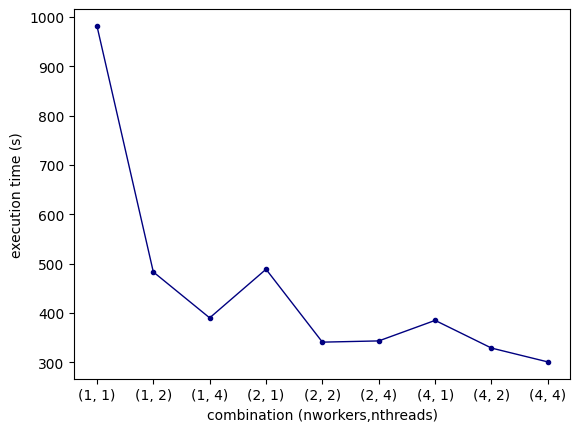

In [28]:
logging.getLogger("distributed").setLevel(logging.WARNING) #this ensures only warning logs are displayed, providing a clear output
time_of_execution = datetime.now(pytz.timezone('Europe/Rome')).strftime('%d-%m-%y-%H%M')
combinations = [(1,1), (1,2), (1,4), (2,1), (2,2), (2,4), (4,1), (4,2), (4,4)]
#combinations = [(2,4), (4,4)]

metallicity='Z0.00014_a3_cM70'
n_pairs=40

benchmarking_times = benchmarking(combinations, time_of_execution, user=user, metallicity=metallicity, n_pairs=n_pairs, save=True)
print(benchmarking_times)

plot_benchmarking(benchmarking_times)

The best performance is achieved when the number of workers and threads is set to 4. This is because the code takes full advantage of multithreading. When the number of threads is low, performance is worse because the potential of multithreading isn't fully utilized. The worst performance occurs when both the number of workers and threads is set to 1. In this case, parallelization is limited to the use of the three virtual machines, but we fail to make use of the fact that each virtual machine has a multicore CPU, leading to inefficient resource utilization.

### 6.2 Partitions

Using the optimal combination of workers and threads obtained in the previous section, we now proceed to benchmark the performance based on the number of partitions in the Dask DataFrames.

We begin by determining the default number of partitions selected by Dask:

In [12]:
path_out, path_ev = grab_paths('Z0.00014_a3_cM70')
columns_to_keep = ['ID', 'Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'BEvent', 'PhaseBSE_0', 'PhaseBSE_1', 'GWtime', 'BWorldtime']
df_out = dd.read_csv(path_out, usecols=columns_to_keep)
columns_to_keep_ev = ["#ID", "Mass_0", "Mass_1", "a", "e"]
df_ev =  dd.read_csv(path_ev, usecols=columns_to_keep_ev,  sep='\s+')
print(f'Output partitions {df_out.npartitions}')
print(f'Evolved partitions {df_ev.npartitions}')

Output partitions 1200
Evolved partitions 40


We then proceed with the benchmarking, keeping the same ratio between the partions of the two dataset as the default one chosen by dask. 

In [16]:
def benchmarking_partitions(npartitions, time_of_execution, user, metallicity, n_pairs, save=True):
    """
    This function calculates the time it takes for each number of partions of the dask dataframes to completely analyze 
    one of the two dataset. 
    It is possible to process a reduced number of file pairs for timing reasons.
    
    Args:
        npartitions (list): integers, indicating the number of partitions.
        time_of_execution (str): the datetime at which the benchmarking computation begin, to be used for naming the output file.
        user (str): your username.
        metallicity (str): for specifying which dataset to use.
        n_pairs (int): the number of file-pairs to be processed for each combination of workers-threads.
        save (bool): if you want to save the output in an external .csv
 
    
    Returns:
        dataframe: times for each number of partitions.
    """
    
    kill_dask_processes(user) #to be sure no active processes interfere

    #start the cluster
    cluster, client = init_client(nworkers=4, nthreads=4, password=password)
    
    times_vs_comb = []
    for n in npartitions:
        try: 
            print("Executing ", n)

            #dataset processing
            start_time = time.time()
            paths = grab_paths(metallicity, n=n_pairs)
            final_data = final_analysis(paths, npartitions=n).compute()
            end_time = time.time()
            
            #Storing the time of execution
            elaps_time = round(end_time-start_time,2) #seconds
            
            minutes = int(elaps_time // 60) #conversion to minutes
            remaining_seconds = round(elaps_time % 60, 1)
            elaps_time_minutes = str(minutes)+" m "+str(remaining_seconds)+" s"
 
            print("exec time: ", elaps_time_minutes, "(", elaps_time, " s)")

            times_vs_comb.append([n,elaps_time, elaps_time_minutes])

            print('end\n')   
            
        #if the code crashes
        except Exception as e: 
            print("Error: Executing exception block" ) 
            print("The exception was triggered by the following error: \n", e, '\n')         
    print("End processing")
    
    #saving the results
    if len(times_vs_comb)>0 and save==True:
        columns = ['(nworkers,n_threads)', 'time[s]', 'time[min]']   
        df = pd.DataFrame(times_vs_comb, columns=columns).set_index('(nworkers,n_threads)')
        
        df.to_csv('./benchmarking/' + 'part' + metallicity[3:metallicity.find('_')] + '_' + str(n_pairs)+ '_'+ time_of_execution+'.csv')
        print("\nSaved results")   

    return df

In [19]:
partitions = [100, 500, 1200, 2000]
logging.getLogger("distributed").setLevel(logging.WARNING) #this ensures only warning logs are displayed, providing a clear output
time_of_execution = datetime.now(pytz.timezone('Europe/Rome')).strftime('%d-%m-%y-%H%M')

metallicity='Z0.00014_a3_cM70'
n_pairs=40

benchmarking_times = benchmarking_partitions(partitions, time_of_execution, user=user, metallicity=metallicity, n_pairs=n_pairs, save=True)
print(benchmarking_times)

Terminating process 226369 - /usr/bin/python3 -m distributed.cli.dask_spec --spec {"cls": "distributed.Scheduler", "opts": {"dashboard_address": ":8787"}}
Terminating process 226442 - /usr/bin/python3 -m distributed.cli.dask_spec tcp://10.67.22.174:33175 --spec {"0": {"cls": "distributed.Nanny", "opts": {"nthreads": 4}}, "1": {"cls": "distributed.Nanny", "opts": {"nthreads": 4}}, "2": {"cls": "distributed.Nanny", "opts": {"nthreads": 4}}, "3": {"cls": "distributed.Nanny", "opts": {"nthreads": 4}}}
Executing  100
exec time:  5 m 44.4 s ( 344.4  s)
end

Executing  500
exec time:  4 m 43.9 s ( 283.9  s)
end

Executing  1200
exec time:  4 m 48.4 s ( 288.43  s)
end

Executing  2000
exec time:  4 m 41.8 s ( 281.77  s)
end

End processing

Saved results
                      time[s]   time[min]
(nworkers,n_threads)                     
100                    344.40  5 m 44.4 s
500                    283.90  4 m 43.9 s
1200                   288.43  4 m 48.4 s
2000                   281.77  4 

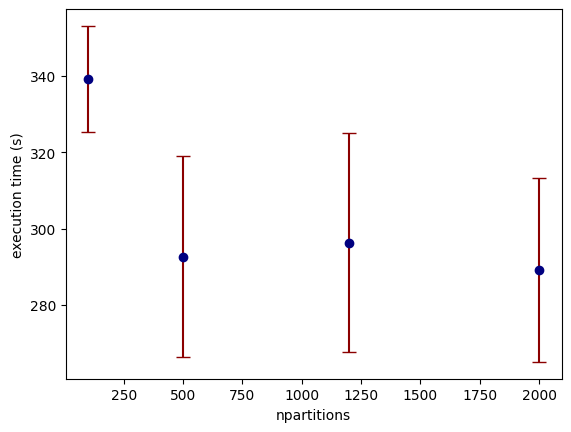

In [40]:
paths = ["./benchmarking/part00014_40_02-09-24-1920.csv", "./benchmarking/part00014_40_02-09-24-2035.csv", 
            "./benchmarking/part00014_40_02-09-24-2057.csv", "./benchmarking/part00014_40_02-09-24-2120.csv"]

dfs = [pd.read_csv(path) for path in paths]
df = pd.concat(dfs)
df = df.rename(columns={'(nworkers,n_threads)': '(npartitions)'})

grouped = df.groupby('(npartitions)')['time[s]']
mean_times = grouped.mean()
std_times = grouped.std()


plt.errorbar(mean_times.index, mean_times, yerr=std_times, fmt='o', color='navy', ecolor='darkred', capsize=5, label='Mean Time ± Std Dev')
plt.xlabel('npartitions')
plt.ylabel('execution time (s)')
plt.show()

The plot indicates that the execution times for various number of partition are generally good, with the exception of the lowest one. This suggests that increasing the number of partitions improves performance to a point, but having too few partitions can negatively impact performance. 